# **Проект по А/B-тестированию**

## Содержание



1.   [Цели исследования](#1)
2.   [Предобработка данных](#2)
3.   [Исследовательский анализ данных](#3)
4.   [Проверка гипотезы](#4)
5.   [Выводы](#5)



# Цели исследования <a id = "1"> </a>

Провести A/B тестирование. Оценить корректность проведения теста. Обратить внимание на:
Время проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями;
Аудиторию теста. Удостовериться, что нет пересечений с конкурирующим тестом. Проверить равномерность распределения по тестовым группам и правильность их формирования.
Проанализировать результаты теста.

Техническое задание




Название теста: recommender_system_test;




Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной - рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
конверсии в просмотр карточек товаров — событие product_page
просмотры корзины — product_card
покупки — purchase.


In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go


In [2]:
#загрузка файлов на colab google
#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
  #print('User uploaded file "{name}" with length {length} bytes'. format(name = fn, length = len(uploaded[fn])))


## Предобработка данных <a id = "2"> </a>

In [ ]:
#читаем файлы
events = pd.read_csv('ab_project_marketing_events.csv')
new_users= pd.read_csv('final_ab_new_users.csv', parse_dates = ['first_date'])  
final_events = pd.read_csv('final_ab_events.csv', parse_dates=['event_dt'])
participants = pd.read_csv('final_ab_participants.csv')

In [4]:
#функция просмотра файлов
def info(df):
    df = df.copy()
    display(df.info())
    display(df.head())

ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;




Структура файла:
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

In [5]:
events.sort_values(by = 'start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Тестирование совпало с 2-мя промо на конец декабря: Christmas&New Year Promo с 2020-12-25 и CIS New Year Gift Lottery с 2020-12-30. CIS New Year Gift Lottery рекламируется только для граждан CIS, но Christmas&New Year Promo направлен на аудиторию EU, что могло ухудшить показатели  нашего A/B теста

final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;




Структура файла:
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

In [6]:
info(new_users)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [7]:
print('Минимальная дата в файле: ', new_users['first_date'].min())

Минимальная дата в файле:  2020-12-07 00:00:00


In [8]:
print('Максимальная дата в файле: ',new_users['first_date'].max())

Максимальная дата в файле:  2020-12-23 00:00:00


Очищаем данные от пользователей, зарегистрировавшихся после 21 декабря и оставляем только пользователей из EU по требованию ТЗ

In [9]:
#срез данных и сохранение нового датафрейма
new_users_filtered = new_users.query('first_date < "2020-12-22" & region == "EU"' )

In [10]:
new_users_filtered

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
9,FFCEA1179C253104,2020-12-07,EU,Android
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [11]:
# Сумма уникальных пользователей
new_users_filtered['user_id'].nunique()

42340

In [12]:
#сумма дубликатов 
new_users_filtered.duplicated().sum()

0

In [13]:
#сумма пропущенных
new_users_filtered.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;




Структура файла:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

In [14]:
info(final_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [15]:
print('Минимальная дата в файле',final_events['event_dt'].min())

Минимальная дата в файле 2020-12-07 00:00:33


In [16]:
print('Максимальная дата в файле',final_events['event_dt'].max())

Максимальная дата в файле 2020-12-30 23:36:33


Активность исчезает после 30 декабря. Либо сайт не работает, либо здесь не все данные

In [17]:
#уникальные наменования событий
final_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

В этом датасете есть еще новые зарегистрированные пользователи login до 21 декабря , их оставим, остальных удалим

In [18]:
#срез данных и сохрание нового датафрейма
final_events_filtered = (
    final_events[~((final_events['event_name'] == "login") & (final_events['event_dt'] > "2020-12-21"))]
)

In [19]:
#проверим дубликаты
final_events_filtered.duplicated().sum()

0

In [20]:
#сумма пропущенных значений
final_events_filtered.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       303618
dtype: int64

In [21]:
#заполнение пропущенных значений
final_events_filtered.fillna(value = '')

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
366353,1DB53B933257165D,2020-12-20 09:52:20,login,
366354,538643EB4527ED03,2020-12-20 14:43:58,login,
366355,7ADEE837D5D8CBBD,2020-12-20 02:23:24,login,
366356,1C7D23927835213F,2020-12-20 14:14:28,login,


final_ab_participants.csv — таблица участников тестов.




Структура файла:
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя

In [22]:
info(participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [23]:
#уникальные значения 
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [24]:
#сумма уникальных значений
participants['user_id'].nunique()

16666

Длина датафрейма 18 268, а сумма уникальных пользовалетелей 16 666. Есть пользователи, попадающие либо в 2 промо, либо в 2 группы A/B теста. В любом случае очищаем данные от них

In [25]:
#группировка по user_id, подсчет количества ab_test
#срез по количеству <2
#список пользователей
list = (participants.\
groupby('user_id')['ab_test'].count().\
reset_index()[participants.\
groupby('user_id')['ab_test'].count().\
reset_index()['ab_test'] < 2]
['user_id']).to_list()

Оставляем только тех пользователей, которые участвуют в тесте recommender_system_test и в 1 группе A или B

In [26]:
participants_filtered = (
    participants.query('ab_test == "recommender_system_test" & user_id in @list')
)

In [27]:
participants_filtered

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


In [28]:
participants_filtered.duplicated().sum()

0

In [29]:
participants_filtered['user_id'].nunique()

5099

Количество уникальных пользователей 5099, что ниже заявленного в ТЗ 6000

<p style="font-family: verdana; color: dodgerblue">Верно</p>

Далее объединяем датафреймы в один в 2 шага методом merge. Сначала new_users_filtered (все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года) и final_events_filtered (все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года), оставляя все строки. Затем participants_filtered (таблица участников тестов)

In [30]:
#объединение 2-х датафреймов по user_id, оставляя все строки
df = new_users_filtered.merge(final_events_filtered, how = 'outer', on ='user_id')

In [31]:
#объединение 2-х даатфреймов по user_id, оставляя только совпадения
df = df.merge(participants_filtered, on = 'user_id' , how = 'inner')

In [64]:
info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17753 entries, 0 to 17752
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     17753 non-null  object        
 1   first_date  16699 non-null  datetime64[ns]
 2   region      16699 non-null  object        
 3   device      16699 non-null  object        
 4   event_dt    15531 non-null  datetime64[ns]
 5   event_name  15531 non-null  object        
 6   details     2483 non-null   float64       
 7   group       17753 non-null  object        
 8   ab_test     17753 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.4+ MB


None

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,A,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07,EU,Android,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test
3,831887FE7F2D6CBA,2020-12-07,EU,Android,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test
4,831887FE7F2D6CBA,2020-12-07,EU,Android,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test


In [32]:
#проверяем условие, что дата регистрации больше или равна дате события
df.loc[df['first_date'] >= df['event_dt']]

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test


В объединенном датафрейме нет строк, попадающих под условие, что дата регистрации больше или равна дате события

In [33]:
#пустые строки событий, сумма
df['event_name'].isnull().sum()

2222

In [34]:
#пустые строки дат событий, сумма
df['event_dt'].isnull().sum()

2222

Пустые строки даты и событий появились из-за добавления таблицы зарегистрированных пользователей new_users_filtered, значит заполним образовавшиеся пустые строки новыми значениями login и датой регистрации

In [35]:
#заполняем пустые строки события login
df['event_name'] = df['event_name'].fillna(value = 'login')

In [36]:
#заполняем пустые строки даты first_date
df['event_dt'] = df['event_dt'].fillna(value = df['first_date'])

In [37]:
df['device']  = df['device'].fillna(value = ' ')

In [38]:
df['details'] = df['details'].fillna(value = '')

In [39]:
df[['user_id', 'event_dt', 'event_name', 'group']]

,user_id,event_dt,event_name,group
0,D72A72121175D8BE,2020-12-07 21:52:10,product_page,A
1,D72A72121175D8BE,2020-12-07 21:52:07,login,A
2,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,A
3,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,A
4,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,A
...,...,...,...,...
17748,4C651540283E1CB7,2020-12-19 20:27:55,login,B
17749,4C651540283E1CB7,2020-12-20 20:48:43,login,B
17750,22A2FA654183E34B,2020-12-19 12:59:33,login,A
17751,8CBAB0A405CB98CF,2020-12-20 03:16:58,login,A


Выводы по данным. Следуя ТЗ, оставили только те данные для исследования, которые нам подходят. Очистили от зарегистрировавшихся после 21 декабря, пользователей, участвующих в двух промо, объединили в один датафрейм, заполнили пустые строки. Нашли ошибки: количество пользователей после предобработки сократилось до 5099, хотя в задании указана необходимость 6000. 


## Исследовательский анализ данных <a id  = "3"> </a>

Рассмотрим группу A

In [40]:
#группировка и подсчет количества событий
#группы А
#сортировка по убыванию
df.\
query('group == "A"').\
groupby('event_name')['user_id'].count().\
reset_index().\
sort_values(by = 'user_id', ascending = False)

,event_name,user_id
0,login,4655
2,product_page,4250
1,product_cart,1989
3,purchase,1973


In [41]:
#группировка и подсчет количества уникальных событий
#группы А
#сортировка по убыванию
df_A = df.\
query('group == "A"').\
groupby('event_name')['user_id'].nunique().\
reset_index().\
sort_values(by = 'user_id', ascending = False)
df_A

,event_name,user_id
0,login,2605
2,product_page,1360
3,purchase,652
1,product_cart,631


Пользователи проходят регистрацию по 2 раза в среднем. Конверсия в просмотр товаров 50% и конверсия в оплату 50%. 

In [42]:
#группировка по событиям и устройствам
#подсчет количества уникальных пользователей
#срез по группе А
df.\
query('group == "A"').\
groupby(['device', 'event_name']).agg({'user_id' : 'nunique'}).\
reset_index().\
sort_values(by = 'user_id', ascending = False)

,device,event_name,user_id
4,Android,login,1080
12,PC,login,652
6,Android,product_page,545
16,iPhone,login,523
14,PC,product_page,331
7,Android,purchase,269
5,Android,product_cart,264
18,iPhone,product_page,262
8,Mac,login,226
15,PC,purchase,152


Больше всего регистрируются через ANDROID, в 2 раза меньше через PC  и примерно столько же через Iphone

In [43]:
#сумма покупок группы A
df.\
query('group == "A"').\
groupby('event_name').agg({'user_id' : 'count', 'details' : 'sum'}).\
reset_index().\
sort_values(by = 'user_id', ascending = False)

,event_name,user_id,details
0,login,4655,
2,product_page,4250,
1,product_cart,1989,
3,purchase,1973,45655.3


Рассмотрим группу B

In [44]:
df.\
query('group == "B"').\
groupby('event_name')['user_id'].count().\
reset_index().\
sort_values(by = 'user_id', ascending = False)

,event_name,user_id
0,login,2795
2,product_page,1048
1,product_cart,533
3,purchase,510


In [45]:
df_B = df.\
query('group == "B"').\
groupby('event_name')['user_id'].nunique().\
reset_index().\
sort_values(by = 'user_id', ascending = False)
df_B

,event_name,user_id
0,login,2025
2,product_page,397
3,purchase,198
1,product_cart,195


Повторных регистраций группы B на 50% меньше, чем А. Конверсия в просмотр товара 20%, в покупку 50%.

In [47]:
df.\
query('group == "B"').\
groupby(['device', 'event_name']).agg({'user_id' : 'nunique'}).\
reset_index().\
sort_values(by = 'user_id', ascending = False)

,device,event_name,user_id
4,Android,login,913
12,PC,login,477
16,iPhone,login,421
6,Android,product_page,175
8,Mac,login,173
7,Android,purchase,93
5,Android,product_cart,82
14,PC,product_page,81
18,iPhone,product_page,74
17,iPhone,product_cart,48


Для группы B больше регистраций через Android, потом pc, потом iphone

In [48]:
df.\
query('group == "B"').\
groupby('event_name').agg({'user_id' : 'count', 'details' : 'sum'}).\
reset_index().\
sort_values(by = 'user_id', ascending = False)

,event_name,user_id,details
0,login,2795,
2,product_page,1048,
1,product_cart,533,
3,purchase,510,11204.9


Сумма покупок ниже,чем у группы A

In [49]:
#Количество событий на пользователя
df.\
query('group == "A"').\
groupby('user_id').agg({'event_name' : 'count'}).\
reset_index().\
sort_values(by = 'event_name', ascending = False)

,user_id,event_name
2334,CED71698585A2E46,21
325,1BFEE479308EFF44,21
660,3AF000EC534B1B09,20
1335,77FC0E20AEAC1506,20
1226,6E3DF9C69A6B607E,20
...,...,...
1407,7F64B89118F6C620,1
1403,7EEFA51F61878981,1
1400,7EA8841B22920FD4,1
1399,7E99823BCDFE0D65,1


In [50]:
#распределение количества событий на пользователя
df.\
query('group == "A"').\
groupby('user_id').agg({'event_name' : 'count'}).\
reset_index().\
sort_values(by = 'event_name', ascending = False).describe()

,event_name
count,2853.000000
mean,4.509989
std,3.738984
min,1.000000
25%,1.000000
50%,4.000000
75%,7.000000
max,21.000000


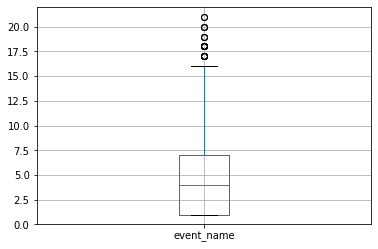

In [51]:
df.\
query('group == "A"').\
groupby('user_id').agg({'event_name' : 'count'}).\
reset_index().\
sort_values(by = 'event_name', ascending = False).boxplot()

In [52]:
df.\
query('group == "B"').\
groupby('user_id').agg({'event_name' : 'count'}).\
reset_index().\
sort_values(by = 'event_name', ascending = False)

,user_id,event_name
135,1198061F6AF34B7B,27
132,115EBC1CA027854A,25
1093,89545C7F903DBA34,21
348,2C2BE85372033F77,20
1004,7E8720DB6A21CF66,20
...,...,...
821,662BFB9FEF6EBA76,1
819,65FF2DBD629DF1A9,1
817,65D320563CCEB78B,1
816,65C5BC2B1645E934,1


In [53]:
df.\
query('group == "B"').\
groupby('user_id').agg({'event_name' : 'count'}).\
reset_index().\
sort_values(by = 'event_name', ascending = False).describe()

,event_name
count,2084.000000
mean,2.344530
std,2.721214
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,27.000000


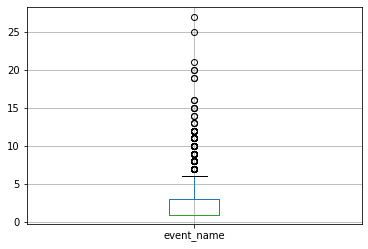

In [54]:
df.\
query('group == "B"').\
groupby('user_id').agg({'event_name' : 'count'}).\
reset_index().\
sort_values(by = 'event_name', ascending = False).boxplot()

Количество событий на пользователя группы A  в среднем 4, на пользователя группы B - 1. 

Text(0.5, 1.0, 'Распределение логов')

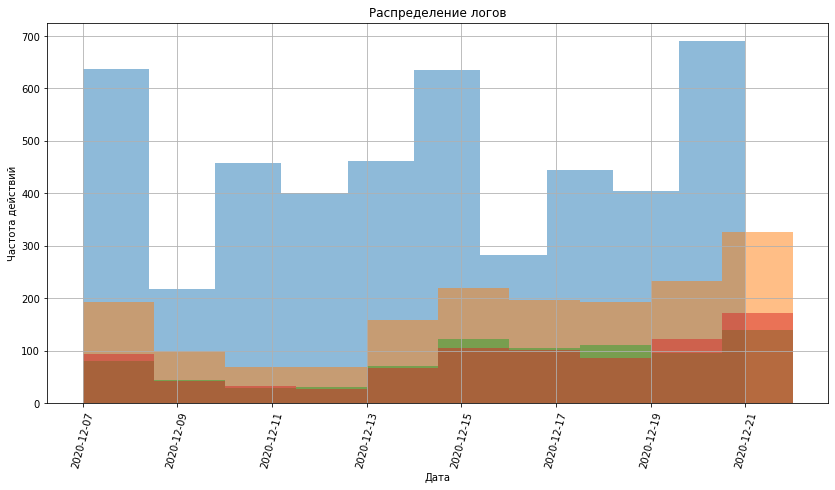

In [55]:
#сводная таблица 
#частота событий по датам
plt.figure(figsize=(14,7))
df_pivot = df.pivot_table(index = 'user_id' , columns = 'event_name', values = 'event_dt', aggfunc = 'min')
df_pivot['login'].hist(alpha = 0.5, xrot = 75)
df_pivot['product_page'].hist(alpha = 0.5)
df_pivot['product_cart'].hist(alpha = 0.5)
df_pivot['purchase'].hist(alpha = 0.5)

plt.ylabel('Частота действий')
plt.xlabel('Дата')
plt.title('Распределение логов')

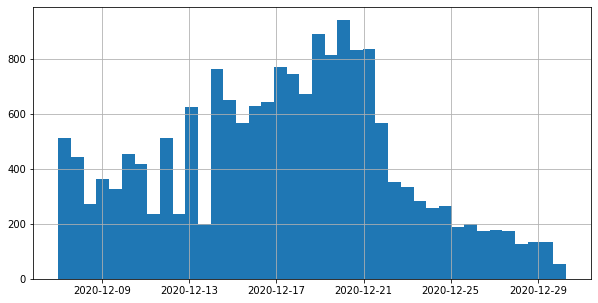

In [56]:
plt.figure(figsize=(10,5))
df['event_dt'].hist(bins=40)

По гистограмме, после 21 декабря совершались только повторные события с теми же пользователями. Каждый 7 день активность пользователей высокая относительно других дней. График повторяет форму каждые 7 дней, в последнюю неделю с 15 по 21 декабря количество просмотров товаров и покупок увеличилось.

Рассмотрим конверсии событий для групп

In [57]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = df_A['event_name'],
    x = df_A['user_id'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = df_B['event_name'],
    x = df_B['user_id'],
    textinfo = "value+percent previous"))

fig.show()

По графику конверсия для группы A: *login - product_page - 52%, product_page - purchase 48%*; для группы B: login - product_page - 20%, product_page - purchase - 50%

## Проверка гипотезы <a id = "4"></a>



Нулевая гипотеза H0 - нет статистически значимой разницы между группами A и B, альтернативная гипотеза H1 - есть статистически значимая разница между группами A и B

In [58]:
result = pd.merge(df_A, df_B, on = 'event_name')
result.rename(columns = {'user_id_x' : 'group_A', 'user_id_y': 'group_B'})

,event_name,group_A,group_B
0,login,2605,2025
1,product_page,1360,397
2,purchase,652,198
3,product_cart,631,195


In [ ]:
for i in [0,1,2]:
  alpha = .05
  p1 = result.loc[i+1,'group_A']/result.loc[i,'group_A']
  p2 = result.loc[i+1,'group_B']/result.loc[i,'group_B']  
  p_combined = (result.loc[i+1,'group_A'] + result.loc[i+1,'group_B']) / (result.loc[i,'group_A'] + result.loc[i,'group_B'])
  difference = p1 - p2
  z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/result.loc[i,'group_A'] + 1/result.loc[i,'group_B']))
  distr = st.norm(0, 1) 

  p_value = (1 - distr.cdf(abs(z_value))) * 2

  print('p-значение: ', p_value)

  if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами  A и B есть значимая разница")
  else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы  A и B разными")

##  Выводы <a id = "5"> </a>

A/B тестирование можно признать некорректным, так как совпадает с другим промо, не хватает количества пользователей для исследовательского анализа согласно ТЗ. Перед проведением теста можно было бы провести A/A тест для проверки корректности и рассчитать размер выборки. 

Для групп больше регистраций через Android, потом pc, потом iphone.
Каждый 7 день активность пользователей высокая относительно других дней. График повторяет форму каждые 7 дней, в последнюю неделю с 15 по 21 декабря количество просмотров товаров и покупок увеличилось.

Ко второй неделе есть увеличение в количестве событий (покупок), возможно связано с новогодними праздниками, данный факт так же негативно сказывается на результатах тестирования. 



<p style="font-family: verdana; color: green">Тестирование совпало с 2-мя промо на конец декабря: Christmas&New Year Promo с 2020-12-25 и CIS New Year Gift Lottery с 2020-12-30. CIS New Year Gift Lottery рекламируется только для граждан CIS, но Christmas&New Year Promo направлен на аудиторию EU, что могло ухудшить показатели нашего A/B теста </p>

Статистически значимая разница в конверсиях между группами есть.
Конверсия группы B регистрация - просмотр товара составляет 20%, по сравнению с группой A -50%. Сумма покупок группы B так же ниже,чем группы A. 

Несмотря на некорректность проведения теста, новая рекомендательная система не показала результаты.


